# Libraries

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools as itertools

import timeit

from itertools import combinations

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,validation_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

import nltk
import nltk.data
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize

# Task 1

## Intuition:

In this task we want to build a regressor to predict SP500 scores for the "most relevant" companies in the dataset.

We start by reading the dataset and invetigating it, then we move forward to getting the corrleation of the SP500 score, and then filtering and obtaining the relevant companies that have a correlation that is either higher than 95% or less than -95%.

After filtering out the irrelevant companies, we normalise the dataset to have a better model perfromance later on. The normalisation technique here is implemented manually for each feature where we subtract the mean of that feature from the values and then divide the result by the standard deviation of the feature. 

We then determine the target variable for our model (SP500) and include all of the relevant companies in the inputs. We split the dataset with a ratio of 50:50 since we found out according to our investigation of the dataset that we have a small dataset at hand ( 1260 rows, 72 columns ).

We then create our MLPRegressor model to predict the SP500 scores. Since our dataset is small in number of datapoints and features, we use a small size of hidden layers and nodes (2 layers with 50 nodes each). In addition we use activation function relu and the optimizer adam for their effective results with general datasets. We also prevent overfitting by 2 approaches, specifying a maximum number of iterations to be 1000 where we don't want it to run forever and at the same time take time to converge successfully especially that we use a considerably low value for the learning rate  = 0.01 to let the network achieve a stable state to generlize the output, and we also use an alpha factor of 0.0001 in order to prevent overfitting.

After we get the predicted values, we de-normalise the predicted and actual scores of the SP500 scores by reversing the normalisation technique.

We then create a plot for a certain number of points (300 in this case), then we plot both of the actual and predicted values on the plot with the colours red and blue to signify the difference.

It is important to note that we also plot values between the actual and predicted points for each point with a colour scheme of green, so that we can detect the mismatches that occur in the predictions as the green pllottings will only be visible if there is a considerable distance between the actual and predcited values for each point. We can see in the final plot that actual and predicted values are mostly matched correctly as there are very few green points visible, whereas for values above 2400 the green values are more visible in the plot. This might be due to lack of values greater than 2400 in the training set when compared to values less than 2400.

## Functions

In [2]:
def getKeysByValue(dictOfElements):
    
    # Create an empty list
    listOfKeys = list()
    
    # Form tuples of dictionary elements in the form of (Stock Company, Correlation Score)
    listOfItems = dictOfElements.items()
    
    # Check for each tuple
    for item  in listOfItems:
        # Check if the correlation score is greater than or equal 0.95, or less than or equal -0.95
        if ( (item[1] >= 0.95) | (item[1] <= -0.95) ):
            # If true, append the list with the stock company
            listOfKeys.append(item[0])
            
    # Return the list of stocck companies with relevant correlations
    return  listOfKeys

def normalizeDF(df):
    for column in list(df):
        if( (df[column].dtype == np.float64 or df[column].dtype == np.int64) ):
            df[column]  = ( df[column] - df[column].mean() ) / df[column].std()
    df = df.fillna(0)
    return df

## Read and Investigate the Dataset

In [3]:
df = pd.read_csv('sp500_27270.csv')

In [4]:
print('Shape of Dataframe: ', df.shape)

Shape of Dataframe:  (1260, 388)


In [5]:
df.head()

,Unnamed: 0,SP500,MMM,ABT,ABBV,ACN,ATVI,AYI,ADBE,AMD,...,WMB,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
0,0,1676.12,104.8617,30.0317,38.7049,64.8930,16.0295,94.7727,50.820,3.86,...,27.0806,139.1379,22.8062,23.7407,41.0246,26.1189,46.4083,79.8048,25.8329,30.7332
1,1,1655.45,103.5100,29.5924,37.3865,63.7629,15.8936,93.2675,49.580,3.72,...,26.7222,137.5369,23.1504,23.1472,40.3263,25.5592,46.5642,79.9583,25.7091,30.3482
2,2,1656.40,103.8722,29.7359,37.6300,63.8719,15.8062,91.6441,49.450,3.65,...,26.6536,137.9919,23.3099,23.3070,40.3882,25.3820,43.4164,81.2242,25.6233,30.2520
3,3,1692.56,105.4360,30.2850,38.7061,64.7626,16.5538,94.5464,51.165,3.79,...,27.2559,142.0337,23.6288,24.3114,41.3517,26.0536,43.0638,82.4135,26.6429,31.1471
4,4,1703.20,106.6552,30.3931,38.6807,66.0803,16.5829,96.2288,52.190,3.83,...,27.5609,145.7606,23.7295,24.2886,41.7928,26.2122,43.7560,83.1136,26.9859,31.1856


## Check Correlation of Features with the SP500 Score

In [6]:
# Get the correlation of the SP500 column with the other columns
sp = df.corr()['SP500']

# Convert the correlation series to a dictionary
sp = sp.to_dict()

# Get the columns with the relevant correlation
relevantColumns = getKeysByValue(sp)
print('Length of Relevant Columns:', len(relevantColumns))

# For later use to denormalise the Predicted and Actual SP500 values when plotting
Y_mean = df['SP500'].mean()
Y_std = df['SP500'].std()

# Use only the relevant columns with the required correlations obtained from the getKeysByValue() Function
df = df[relevantColumns]

# Normalise the dataset for each column by subtracting the mean and dividing by the standard deviation
df = normalizeDF(df)

Length of Relevant Columns: 72


In [7]:
df.head()

,SP500,ACN,ATVI,ADBE,AET,AFL,A,ALL,AMT,APH,...,TMK,TSS,TDG,UNH,V,WM,WAT,XYL,YUM,ZTS
0,-1.716195,-1.453476,-1.224364,-1.113314,-1.459529,-0.888746,-1.078709,-1.443016,-1.626664,-1.594139,...,-1.325041,-1.201220,-1.701314,-1.275263,-1.378901,-1.391655,-1.172767,-1.352361,-1.157063,-1.197599
1,-1.782215,-1.491501,-1.231322,-1.134398,-1.480694,-0.943175,-1.136224,-1.499429,-1.670551,-1.622674,...,-1.369711,-1.222969,-1.702211,-1.286267,-1.413420,-1.411069,-1.203654,-1.389733,-1.144800,-1.219826
2,-1.779181,-1.487833,-1.235797,-1.136608,-1.490909,-0.933990,-1.146572,-1.474293,-1.680943,-1.597638,...,-1.376620,-1.222484,-1.722645,-1.287863,-1.401431,-1.415793,-1.215200,-1.401565,-1.392402,-1.225381
3,-1.663686,-1.457864,-1.197521,-1.107447,-1.445909,-0.839975,-1.086759,-1.416201,-1.605106,-1.583367,...,-1.274845,-1.189623,-1.690873,-1.246397,-1.354373,-1.372235,-1.171035,-1.356721,-1.420137,-1.173702
4,-1.629701,-1.413527,-1.196031,-1.090019,-1.451016,-0.778475,-1.059729,-1.386040,-1.572385,-1.558039,...,-1.261948,-1.169815,-1.692220,-1.241773,-1.325576,-1.345470,-1.153427,-1.346131,-1.365689,-1.171480


## Prepare Training and Testing Sets

In [8]:
# Store target variable
Y = df['SP500']

# Delete target variable from dataframe
del df['SP500']

In [9]:
# Get values of the dataframe after removal of the target variable
X = df.values

# Split the dataset into training and testing sets with a ration of 0.6:0.4
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.5,random_state=1)

In [10]:
# ADAM Optimiser
reg = MLPRegressor( 
                    hidden_layer_sizes=(50, 50),
                    activation='relu',
                    solver='adam',
                    learning_rate='adaptive',
                    max_iter=1000,
                    learning_rate_init=0.01,
                    alpha=0.0001
                  )

reg.fit(X_train, Y_train)

Y_pred = reg.predict(X_test)

print('Training Score: ', reg.score(X_train, Y_train))
print('Mean Absolute Error: ',mean_absolute_error(Y_test, Y_pred))

seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score( reg, X_train, Y_train, cv=kfold )
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Training Score:  0.9983495610209804
Mean Absolute Error:  0.034380146841172
Results: 1.00 (0.00) MSE


## Denormalise SP500 Values, and Plot the Actual vs Predicted Values for 200 Points

In [12]:
# Denormalise the Target Testing and Predicted Values
newY_test = (Y_test * Y_std) + Y_mean
newY_pred = (Y_pred * Y_std) + Y_mean

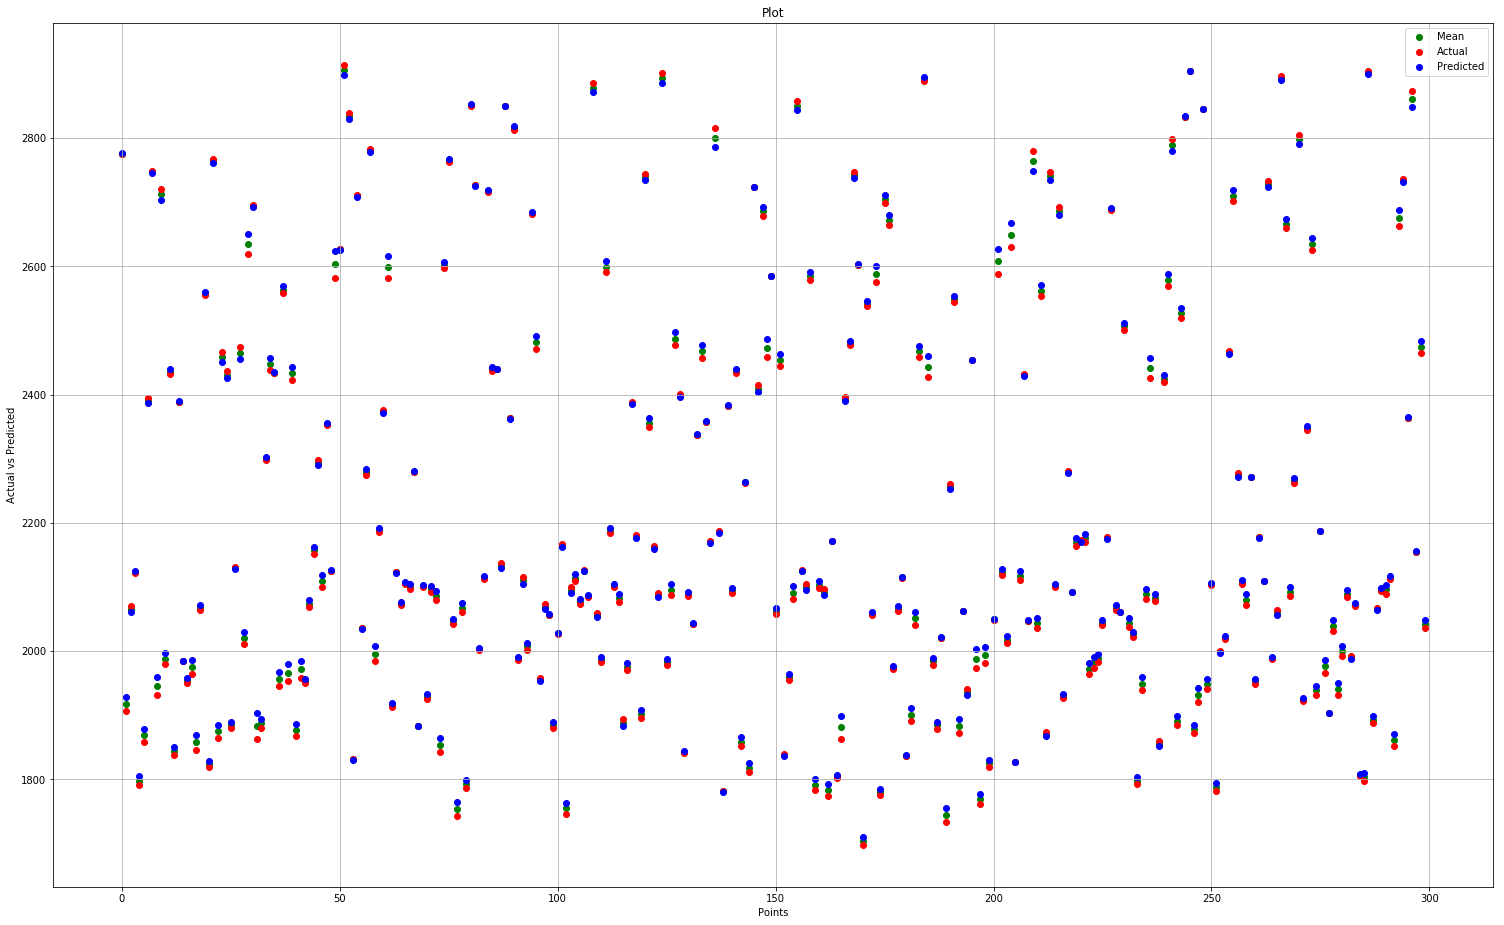

In [13]:
# Define Plotting Figure Parameters
fig = plt.figure()
fig.set_size_inches(25, 15)
ax = fig.add_axes([0.1,0.1,0.8,0.8])
ax.grid()

# Define a range for n elements for n points (200 in this case)
numberOfPoints = 300
xAxis = np.arange(0,numberOfPoints)

ax.scatter(xAxis,(newY_test[0:numberOfPoints] + newY_pred[0:numberOfPoints])/2,label='Mean',color='green')

# Plot the 1st n elements of the actual values (200 in this case) aganist the points with a colour of red
ax.scatter(xAxis,newY_test[0:numberOfPoints],label='Actual',color='red')

# Plot the 1st n elements of the predicted values (200 in this case) aganist the points with a colour of red
ax.scatter(xAxis,newY_pred[0:numberOfPoints],label='Predicted',color='blue')


# Define Plotting Lables
ax.legend(loc='best')
ax.set_xlabel('Points')
ax.set_ylabel('Actual vs Predicted')
ax.set_title('Plot')

plt.show()

# Task 2

## Intuition:

In this task we want to build a regressor to predict stock values for the 4 upcoming days of the "most relevant company" to the SP500 score.

We start by reading the dataset and invetigating it, then we move forward to getting the corrleation of the SP500 score, and then filtering and obtaining the company that has the highest correlation amongst the companies (APH with a correlation of around 98.8%).

In order to predict the stock value for the 4 upcoming days, we are going to use the stock values for the previous days in addition to today's stock value to try and predict the desired features. After getting the most relevant company, we form 8 additional features representing 4 days before and 4 days after each time period, where each feature represents a period of time with respect to the day being investigated (Example: Feature '-4' is the stock 4 days before the current day, Feature '4' is the stock 4 days after the current day, etc.)

After preparing the features, we split the dataset with a ratio of 50:50 since we found out according to our investigation of the dataset that we have a small dataset at hand ( 1260 rows, 72 columns ).

We then create our MLPRegressor model to predict the Stock values. Since our dataset is small in number of datapoints and features, we use a small size of hidden layers and nodes (2 layers with 50 nodes each). In addition we use activation function relu and the optimizer adam for their effective results with general datasets. We also prevent overfitting by 2 approaches, specifying a maximum number of iterations to be 1000 where we don't want it to run forever and at the same time take time to converge successfully especially that we use a considerably low value for the learning rate  = 0.01 to let the network achieve a stable state to generlize the output, and we also use an alpha factor of 0.0001 in order to prevent overfitting.

After we get the predicted values, we de-normalise the predicted and actual scores of the stock values by reversing the normalisation technique.

We then create a plot for a certain number of points (3 in this case), then we plot the input given to predict the values (-4 days before ... today) in addition to both the actual and predicted stock values for the next 4 days, with colour schemes of green, red, blue respectively.

## Functions

In [14]:
def getKeyByValue(dictOfElements, maxValue):
    
    # Return key variable
    key = ''
    
    # Form tuples of dictionary elements in the form of (Stock Company, Correlation Score)
    listOfItems = dictOfElements.items()
    
    # Check for each tuple
    for item  in listOfItems:
        # Check if the correlation score is equal to the maxValue provided
        if item[1] ==maxValue :
            # If true, assign variable key to this value and break the loop
            key = item[0]
            break
            
    # Return the list of stocck companies with relevant correlations
    return  key

def normalizeDF(df):
    for column in list(df):
        if( (df[column].dtype == np.float64 or df[column].dtype == np.int64) ):
            df[column]  = ( df[column] - df[column].mean() ) / df[column].std()
    df = df.fillna(0)
    return df

## Read the Dataset

In [15]:
df = pd.read_csv('sp500_27270.csv')

In [16]:
# Get the correlation of the SP500 column with the other columns
corr = df.corr()
sp = corr['SP500']

# Delete SP500's correlation with itself as it will be the highest correlation
del sp['SP500']

# Get highest correlation value with SP500 (After removal of SP500 itself)
maxValue = sp.max()
print('Highest Correlation:', maxValue)

# Convert the correlation series to a dictionary
sp = sp.to_dict()

# Get the stock company with the highest correlation to SP500
mostRelevantColumn = getKeyByValue(sp, maxValue)

# Select column of the stock company in the dataframe
df = df[[mostRelevantColumn]]
df.head()

Highest Correlation: 0.9883608178608217


,APH
0,36.2702
1,35.8013
2,36.2127
3,36.4472
4,36.8634


In [17]:
# Create day intervals from -4 days in the past to 4 days in the future
for interval in [-4, -3, -2, -1, 1, 2, 3, 4]:
    columnName = str(interval)
    df[columnName] = df[mostRelevantColumn].shift(-1*interval)
    
# Choose relevant columns in the dataframe (Time intervals in addition to "current day")
df = df[['-4', '-3', '-2', '-1', mostRelevantColumn, '1', '2', '3', '4']]

# Drop Null values resulting from the shift operation
df = df.dropna()

# For later use to denormalise the Predicted and Actual stock company values when plotting
dfMeans = [df['1'].mean(), df['2'].mean(), df['3'].mean(), df['4'].mean()]
dfStandardDeviations = [df['1'].std(), df['2'].std(), df['3'].std(), df['4'].std()]

dfMeansX = [df['-4'].mean(), df['-3'].mean(), df['-2'].mean(), df['-1'].mean(), df['APH'].mean()]
dfStandardDeviationsX = [df['-4'].std(), df['-3'].std(), df['-2'].std(), df['-1'].std(), df['APH'].std()]

# Normalise the dataset for each column by subtracting the mean and dividing by the standard deviation
df = normalizeDF(df)

# Show 1st 5 rows of the dataframe after formation of the interval columns
df.head()

,-4,-3,-2,-1,APH,1,2,3,4
4,-1.595081,-1.625917,-1.602875,-1.590577,-1.567090,-1.567632,-1.559441,-1.514839,-1.456488
5,-1.623849,-1.600689,-1.588501,-1.565077,-1.565627,-1.557380,-1.512609,-1.454271,-1.421084
6,-1.598609,-1.586309,-1.562989,-1.563612,-1.555370,-1.510527,-1.452024,-1.418859,-1.420797
7,-1.584222,-1.560786,-1.561524,-1.553350,-1.508493,-1.449914,-1.416601,-1.418572,-1.431033
8,-1.558688,-1.559321,-1.551256,-1.506448,-1.447850,-1.414476,-1.416314,-1.428810,-1.443610


## Prepare Training and Testing Sets

In [18]:
# Target Columns
targetColumns = ['1', '2', '3', '4']
# Store target variable
Y = df[targetColumns]

# Delete target variable from dataframe
df = df[['-4', '-3', '-2', '-1', mostRelevantColumn]]
print(df.head())

# Get values of the dataframe after removal of the target variable
X = df.values

# Split the dataset into training and testing sets with a ration of 0.6:0.4
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.5,random_state=1)

         -4        -3        -2        -1       APH
4 -1.595081 -1.625917 -1.602875 -1.590577 -1.567090
5 -1.623849 -1.600689 -1.588501 -1.565077 -1.565627
6 -1.598609 -1.586309 -1.562989 -1.563612 -1.555370
7 -1.584222 -1.560786 -1.561524 -1.553350 -1.508493
8 -1.558688 -1.559321 -1.551256 -1.506448 -1.447850


In [19]:
# ADAM Optimiser
reg = MLPRegressor( 
                    hidden_layer_sizes=(50, 50),
                    activation='relu',
                    solver='adam',
                    learning_rate='adaptive',
                    max_iter=1000,
                    learning_rate_init=0.01,
                    alpha=0.0001
                  )

reg.fit(X_train, Y_train)

Y_pred = reg.predict(X_test)

print('Training Score: ', reg.score(X_train, Y_train))
print('Mean Absolute Error: ',mean_absolute_error(Y_test, Y_pred))

seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score( reg, X_train, Y_train, cv=kfold )
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Training Score:  0.9944065256721034
Mean Absolute Error:  0.04771728880051414
Results: 0.99 (0.00) MSE


In [20]:
# Denormalise the Target Testing and Predicted Values
newY_pred = (Y_pred*dfStandardDeviations) + dfMeans
newY_test = (Y_test*dfStandardDeviations) + dfMeans
newX_test = (X_test*dfStandardDeviationsX) + dfMeansX

In [21]:
# Print the predicted and actual values for the 1st 4 points
for i in range(0,4):
    print('Point', i+1)
    print('Predicted Values:',list(newY_pred[i]))
    print('Actual Value:\t ', list(newY_test.iloc[i]))
    print('\n')

Point 1
Predicted Values: [55.86774578431705, 55.87103998711069, 56.00734017849913, 55.63069078120463]
Actual Value:	  [55.2159, 55.3611, 55.8063, 56.0192]


Point 2
Predicted Values: [68.10698198540351, 68.29530079151064, 68.36658162053175, 68.13571509276036]
Actual Value:	  [68.2958, 68.3745, 68.4926, 68.7289]


Point 3
Predicted Values: [91.37853042929028, 91.374465913427, 91.62077509201676, 91.24111126787002]
Actual Value:	  [90.5851, 87.7391, 84.913, 86.6644]


Point 4
Predicted Values: [53.34288186070391, 53.27021211604685, 53.3106742436143, 53.281620339894104]
Actual Value:	  [53.5412, 53.9691, 53.0938, 52.1504]




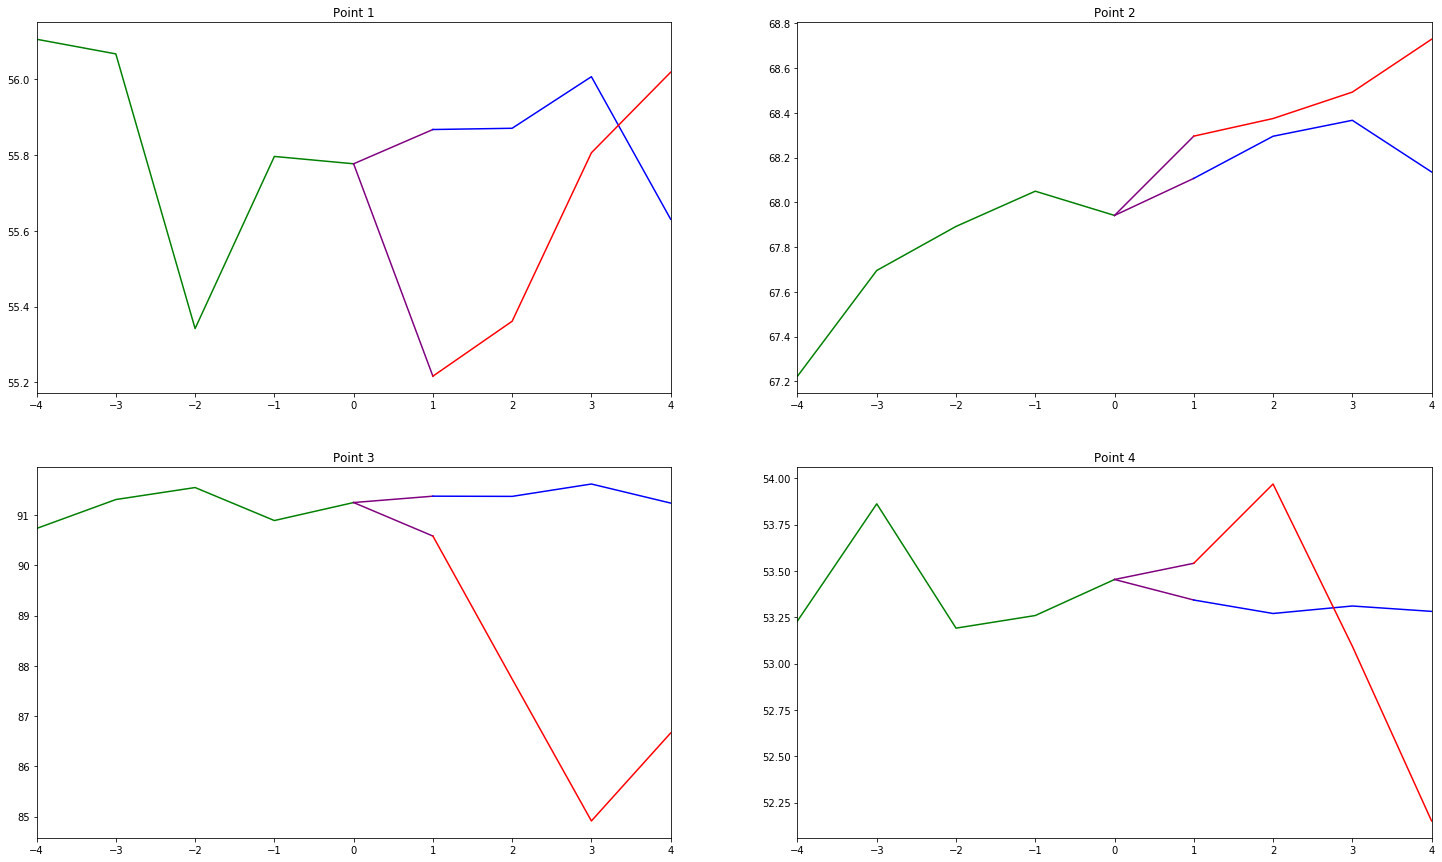

In [26]:
fig = plt.figure()
fig.set_size_inches(25, 15)

#########################################################################################################
#1st Point

plt.subplot(221)

# Define interval points to display values for (-4, -3, ..., 3, 4)
xAxis = np.arange(-4,5)

# Plot the inputs values with a colour of green
plt.plot(xAxis[:5], list((newX_test)[0]),label='Inputs',color='green')

# Plot a line connecting the input to the predicted output values plot with a colour of purple
plt.plot([0,1], [list((newX_test)[0])[-1], list(list(newY_pred)[0])[0]] ,color='purple')

# Plot a line connecting the input to the actual output values plot with a colour of purple
plt.plot([0,1], [list((newX_test)[0])[-1], list(newY_test.iloc[0])[0]] ,color='purple')

# Plot the predicted ouput values with a colour of blue
plt.plot(xAxis[5:], list(list(newY_pred)[0]),label='Predicted',color='blue')

# Plot the actual ouput values with a colour of red
plt.plot(xAxis[5:], list(newY_test.iloc[0]),label='Actual',color='red')

plt.xlim(-4,4)
plt.title('Point 1')

#########################################################################################################
#2nd Point

plt.subplot(222)

# Define interval points to display values for (-4, -3, ..., 3, 4)
xAxis = np.arange(-4,5)

# Plot the inputs values with a colour of green
plt.plot(xAxis[:5], list((newX_test)[1]),label='Inputs',color='green')

# Plot a line connecting the input to the predicted output values plot with a colour of purple
plt.plot([0,1], [list((newX_test)[1])[-1], list(list(newY_pred)[1])[0]] ,color='purple')

# Plot a line connecting the input to the actual output values plot with a colour of purple
plt.plot([0,1], [list((newX_test)[1])[-1], list(newY_test.iloc[1])[0]] ,color='purple')

# Plot the predicted ouput values with a colour of blue
plt.plot(xAxis[5:], list(list(newY_pred)[1]),label='Predicted',color='blue')

# Plot the actual ouput values with a colour of red
plt.plot(xAxis[5:], list(newY_test.iloc[1]),label='Actual',color='red')

plt.xlim(-4,4)
plt.title('Point 2')

#########################################################################################################
#3rd Point

plt.subplot(223)

# Define interval points to display values for (-4, -3, ..., 3, 4)
xAxis = np.arange(-4,5)

# Plot the inputs values with a colour of green
plt.plot(xAxis[:5], list((newX_test)[2]),label='Inputs',color='green')

# Plot a line connecting the input to the predicted output values plot with a colour of purple
plt.plot([0,1], [list((newX_test)[2])[-1], list(list(newY_pred)[2])[0]] ,color='purple')

# Plot a line connecting the input to the actual output values plot with a colour of purple
plt.plot([0,1], [list((newX_test)[2])[-1], list(newY_test.iloc[2])[0]] ,color='purple')

# Plot the predicted ouput values with a colour of blue
plt.plot(xAxis[5:], list(list(newY_pred)[2]),label='Predicted',color='blue')

# Plot the actual ouput values with a colour of red
plt.plot(xAxis[5:], list(newY_test.iloc[2]),label='Actual',color='red')

plt.xlim(-4,4)
plt.title('Point 3')

#########################################################################################################
#4th Point

plt.subplot(224)

# Define interval points to display values for (-4, -3, ..., 3, 4)
xAxis = np.arange(-4,5)

# Plot the inputs values with a colour of green
plt.plot(xAxis[:5], list((newX_test)[3]),label='Inputs',color='green')

# Plot a line connecting the input to the predicted output values plot with a colour of purple
plt.plot([0,1], [list((newX_test)[3])[-1], list(list(newY_pred)[3])[0]] ,color='purple')

# Plot a line connecting the input to the actual output values plot with a colour of purple
plt.plot([0,1], [list((newX_test)[3])[-1], list(newY_test.iloc[3])[0]] ,color='purple')

# Plot the predicted ouput values with a colour of blue
plt.plot(xAxis[5:], list(list(newY_pred)[3]),label='Predicted',color='blue')

# Plot the actual ouput values with a colour of red
plt.plot(xAxis[5:], list(newY_test.iloc[3]),label='Actual',color='red')

plt.xlim(-4,4)
plt.title('Point 4')

plt.show()

# Task 3 Base Requirements

## Intuition:

In this task we wish to build a classifier that can classify the rating of reviews according to the text written in these reviews.

First of all we check the distribution of the reviews and their counts across the dataset to check if we have a balanced dataset. After checking the dataset we find out that we have an unbalanced dataset with very high counts in certain rating classes (4, 5) when compared to other review classes (1, 2, 3). So in order to overcome this imbalance, we take 2500 reviews from each rating class and shuffle them to have a balanced dataset and try to generalise the training as much as possible.

We then split the dataset into training and testing sets with a ratio of 60:40, then we apply the tfidf vectorizer transformation on the reviewText feature in order to form features for the words mentioned in the reviews that will be quantified according to relevance in each review (Maximum number of features = 40000 to save some time in computation).

Then we create the MLP classifier in order to try and predict the classifications for the reviews.Since our dataset is not really small in number of datapoints and features, we use a small size of hidden layers and nodes (1 layers with 250 nodes). In addition we use activation function relu and the optimizer adam for their effective results with general datasets. We also prevent overfitting by 2 approaches, specifying a maximum number of iterations to be 1000 where we don't want it to run forever and at the same time take time to converge successfully especially that we use a considerably low value for the learning rate  = 0.01 to let the network achieve a stable state to generlize the output, and we also use an alpha factor of 0.0001 in order to prevent overfitting.

We then plot for 200 points the actual classifications vs the predicted classifications with mean points to show mismatches between classes (With colour schemes of red, blue, and green), and we will notice that several points mismatch as the accuracy of a model dependant on textual features would not be extremely high (In this case around 57%).

We then plot the confusion matrix which provides us with an important insight, that most of the mismatchings happen between neighboring classes, which makes sense since users usually have different standards when rating products (One user's 4 is probably another user's 5).

## Functions

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [51]:
start_time = timeit.default_timer()

# Read the Dataset
df = pd.read_json('Digital_Music_5.json', lines=True)

# Show number of reviews per each rating
print('Unique counts for each rating:\n\n',df.overall.value_counts())

# Get 2500 rows for each rating
numberOfRows = 2500
df = pd.concat( 
                [(df.loc[df['overall'] == 1]).head(numberOfRows), 
                 (df.loc[df['overall'] == 2]).head(numberOfRows),
                 (df.loc[df['overall'] == 3]).head(numberOfRows),
                 (df.loc[df['overall'] == 4]).head(numberOfRows),
                 (df.loc[df['overall'] == 5]).head(numberOfRows)
                ] )

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Store the Target variable
Y = df['overall']

# Filter the reviewText column in the dataset
X = df['reviewText']

# Split the dataset into training and testing sets with a ration of 0.6:0.4
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.4,random_state=1)

# Define tfidf vectorizer with maximum of 40000 features
tfidf_vectorizer = TfidfVectorizer(max_features=40000)
X_train_transformed = tfidf_vectorizer.fit_transform(X_train)
X_test_transformed = tfidf_vectorizer.transform(X_test)

clf = MLPClassifier( 
                    hidden_layer_sizes=(256),
                    activation='relu',
                    solver='adam',
                    learning_rate='adaptive',
                    max_iter=1000,
                    learning_rate_init=0.001,
                    verbose = True,
                    alpha=0.0001
                  )

clf.fit(X_train_transformed, Y_train)
Y_pred = clf.predict(X_test_transformed)
print(metrics.classification_report(Y_test, Y_pred))
print('Accuracy Score:', clf.score(X_test_transformed, Y_test))

elapsed = timeit.default_timer() - start_time
print('Time in Minutes for Base Requirements Implementation: ', (elapsed/60) )

Unique counts for each rating:

 5    35580
4    16536
3     6789
2     3010
1     2791
Name: overall, dtype: int64
Iteration 1, loss = 1.50095495
Iteration 2, loss = 1.07284988
Iteration 3, loss = 0.69472727
Iteration 4, loss = 0.43425932
Iteration 5, loss = 0.26998536
Iteration 6, loss = 0.17218553
Iteration 7, loss = 0.11356875
Iteration 8, loss = 0.07937714
Iteration 9, loss = 0.05786909
Iteration 10, loss = 0.04349271
Iteration 11, loss = 0.03417959
Iteration 12, loss = 0.02753336
Iteration 13, loss = 0.02295457
Iteration 14, loss = 0.01963930
Iteration 15, loss = 0.01712599
Iteration 16, loss = 0.01515632
Iteration 17, loss = 0.01365186
Iteration 18, loss = 0.01227798
Iteration 19, loss = 0.01142926
Iteration 20, loss = 0.01067346
Iteration 21, loss = 0.01001665
Iteration 22, loss = 0.00936431
Iteration 23, loss = 0.00888513
Iteration 24, loss = 0.00843146
Iteration 25, loss = 0.00807542
Iteration 26, loss = 0.00781584
Iteration 27, loss = 0.00759379
Iteration 28, loss = 0.007259

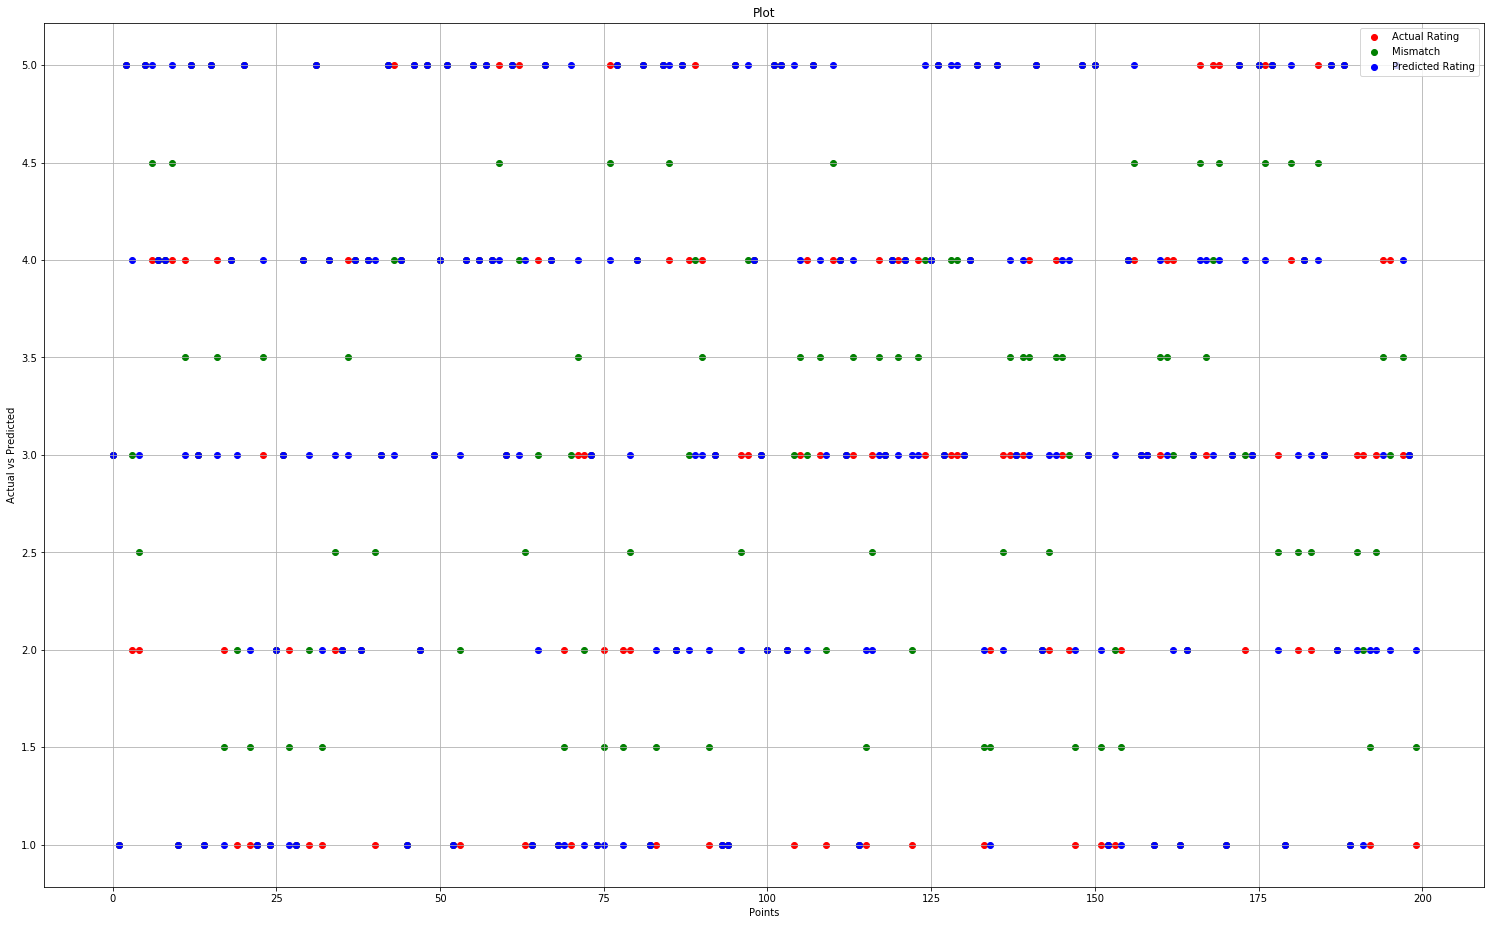

In [54]:
# Define Plotting Figure Parameters
fig = plt.figure()
fig.set_size_inches(25, 15)
ax = fig.add_axes([0.1,0.1,0.8,0.8])
ax.grid()

# Define a range for n elements for n points (200 in this case)
numberOfPoints = 200
xAxis = np.arange(0,numberOfPoints)

# Plot the 1st n elements of the actual values (200 in this case) aganist the points with a colour of red
ax.scatter(xAxis,Y_test[0:numberOfPoints],label='Actual Rating',color='red')

# Plot the mean of the actual and predicted values of the 1st n elements (200 in this case) aganist the points with a colour of green
ax.scatter(xAxis,(Y_test[0:numberOfPoints] + Y_pred[0:numberOfPoints])/2, label='Mismatch', color='green')

# Plot the 1st n elements of the predicted values (200 in this case) aganist the points with a colour of blue
ax.scatter(xAxis,Y_pred[0:numberOfPoints],label='Predicted Rating',color='blue')

# Define Plotting Lables
ax.legend(loc='best')
ax.set_xlabel('Points')
ax.set_ylabel('Actual vs Predicted')
ax.set_title('Plot')

plt.show()

Confusion matrix, without normalization
[[646 258  82  22  22]
 [195 458 199  78  27]
 [ 54 172 471 234  84]
 [ 21  48 205 550 178]
 [ 25  24  59 150 738]]


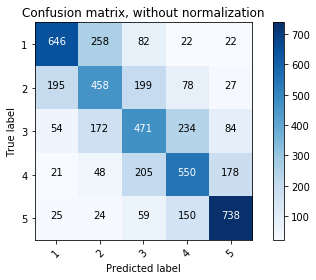

In [55]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1', '2', '3', '4', '5'],
                      title='Confusion matrix, without normalization')

# Task 3 Bonus Implementation

## Intuition:

In the bonus implementation, we try and include more valuable information which can be obtained from the dataset that can help is in our predictions and better classify the reviews.

1st feature that we consider is the 'helpful' feature, which is a list that contains 2 elements representing the upvotes and downvotes on a certain review, which in practical life has a certain correlation where unfairly overaly negative reviews usually tend to be unhelpful whereas fair and moderate review tend to be helpful.

The 2nd feature we are investigating is one that we extract from the reviewText feature, which is a score representing the sentiment of a certain text. We use a modue present in the NLTK module called vader module in order to provide a sentiment score for each review depending on the words present in it (Example: "I love this product" would have a positive sentiment score, whereas "This product is horrible" would provide a negative sentiment score). We believe that this is a relavant feature as it should be able to represent the different classes with its score (Example: A moderatly positive score might indicate a rating of 3 or 4, whereas a generously positive score might indicate a 4 or 5 rating).

We then form a classifier based on only 3 inputs from the 2 features disscussed above (Number of upvotes, Number of downvotes, Sentiment score), and these features alone provide an accuracy score of around 40%. It is important to note that we believe that the suitable activation function for a classifier that uses these features is the logistic (Sigmoid) activation function since we want classification to be dependant on a threshold in our features (Example: A rating to be classified as 5 if upvotes > 20, and sentiment score > 0.3).

We then try 2 approaches with these newly found features:

1. Create a merged classifier that uses the text tfidf features, helpful (upvotes and downvotes), and sentiment features all together to try and classify the reviews.


2. Create some sort of an ensemble classifier, where review ratings are predcicted using each feature separately (One for reviewtext, one for the helpful feature(upvotes and downvotes), and one for the sentiment score), and then create a classifier that takes these 3 predictions and try to predict the final prediction of a given review. 
    
    In order to provide a more convenient input format to the final classifier we use one hot encoding for each feature prediction to have binary inputs where each feature has 5 columns each representing a class of rating (1-5) and only one of these 5 columns is 1 while the others are 0, resulting in 3 of the 15 columns being 1s and the others set to 0. (Example: TextPredicted = '3', HelpfulPredicted = '2', SentimentPredicted = '3' would result in columns Text3, Helpful2, and Sentiment3 to be set to 1 while all other columns are set to 0).
    
    Please note that the activation functions for both helpful and sentiment features are logistic for the previosuly mentioned reasons, while the activation function for the text and final classifier is the relu for their more effective results with the types of inputs provided for both classifiers.
    
Please note that in the implementation below, the accuracy increases but with a small margin, and we believe that a finer tuning of the model parameters for these features will provide an even better result.

## Functions

In [57]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def sentimentScore(text):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(text)
    
    return ss['compound']

def sentimentText(text):
    sentimentLowerBound = -0.3
    sentimentUpperBound = 0.3
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(text)
    
    if ( (ss['compound'] > sentimentLowerBound) & (ss['compound'] < sentimentUpperBound) ):
         result = 'neutral'

    elif (ss['compound'] < sentimentLowerBound):
         result = 'negative'
            
    elif (ss['compound'] > sentimentUpperBound):
         result = 'positive'
        
    return result

## Helpful & Sentiment

In [58]:
start_time = timeit.default_timer()

df = pd.read_json('Digital_Music_5.json', lines=True)

# Get 2500 row for each rating
numberOfRows = 2500
df = pd.concat( 
                [(df.loc[df['overall'] == 1]).head(numberOfRows), 
                 (df.loc[df['overall'] == 2]).head(numberOfRows),
                 (df.loc[df['overall'] == 3]).head(numberOfRows),
                 (df.loc[df['overall'] == 4]).head(numberOfRows),
                 (df.loc[df['overall'] == 5]).head(numberOfRows)
                ] )
# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Split the helpful feature list to two features, the 1st having the 1st value in the list (Upvotes) and the 2nd having the 2nd value in the list (Downvotes)
df[['helpful1','helpful2']] = pd.DataFrame(df.helpful.values.tolist(), index= df.index)

# Put in the helpful feature column the result of subtracting the Downvotes from the Upvotes
#df['helpful'] = df['helpful1'] - df['helpful2']

# Assign binary values to the helpful feature column, if upvotes are greater than or equal the downvotes the value is 1, 0 if downvotes are ore than the upvotes
#df['helpful'] = df.apply(lambda row: 'positive' if row['helpful'] > 0 else 'negative' if row['helpful'] < 0 else 'neutral', axis=1)

# df['negativeH'] = df.apply(lambda row: 1 if row['helpful'] == 'negative' else 0, axis=1)
# df['neutralH'] = df.apply(lambda row: 1 if row['helpful'] == 'neutral' else 0, axis=1)
# df['positiveH'] = df.apply(lambda row: 1 if row['helpful'] == 'positive' else 0, axis=1)

# # Calculate Sentiment for each column
df['sentiment'] = df.apply(lambda row: sentimentScore(row.reviewText), axis=1)

# df['negativeS'] = df.apply(lambda row: 1 if row['sentiment'] == 'negative' else 0, axis=1)
# df['neutralS'] = df.apply(lambda row: 1 if row['sentiment'] == 'neutral' else 0, axis=1)
# df['positiveS'] = df.apply(lambda row: 1 if row['sentiment'] == 'positive' else 0, axis=1)

# Drop unnecssary columns
df = df.drop(['helpful', 'asin', 'reviewerID', 'reviewerName', 'unixReviewTime', 'reviewTime', 'reviewText', 'summary'], axis=1)

print(df.head())
print('\n')
print(df.corr()['overall'])
print('\n')

# Store target variable (It is filtered since the tfidf vectorizer created a column for the word 'overall' as well)
Y = df['overall']

# Delete target variable from dataframe
del df['overall']

# Get values of the dataframe after removal of the target variable
X = df.values

# Split the dataset into training and testing sets with a ration of 0.6:0.4
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.4,random_state=1)

clf = MLPClassifier( 
                    hidden_layer_sizes=(256),
                    activation='logistic',
                    solver='adam',
                    learning_rate='adaptive',
                    max_iter=1000,
                    learning_rate_init=0.001,
                    verbose = True,
                    alpha=0.0001
                  )

clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(metrics.classification_report(Y_test, Y_pred))
print('Accuracy Score:', clf.score(X_test, Y_test))

elapsed = timeit.default_timer() - start_time
print('Time in Minutes for Bonus Implementation: ', (elapsed/60) )

   overall  helpful1  helpful2  sentiment
0        1         6        22     0.5618
1        5         0         1     0.9067
2        4         2         2     0.7096
3        2         3        32     0.5795
4        2         8        12    -0.3612


overall      1.000000
helpful1    -0.014394
helpful2    -0.251683
sentiment    0.415399
Name: overall, dtype: float64


Iteration 1, loss = 1.54906632
Iteration 2, loss = 1.47585301
Iteration 3, loss = 1.43292007
Iteration 4, loss = 1.40008619
Iteration 5, loss = 1.37440875
Iteration 6, loss = 1.35530919
Iteration 7, loss = 1.34348550
Iteration 8, loss = 1.33592193
Iteration 9, loss = 1.33158322
Iteration 10, loss = 1.32605296
Iteration 11, loss = 1.32220553
Iteration 12, loss = 1.32124358
Iteration 13, loss = 1.31805369
Iteration 14, loss = 1.31824581
Iteration 15, loss = 1.31642801
Iteration 16, loss = 1.31792113
Iteration 17, loss = 1.31717069
Iteration 18, loss = 1.31588260
Iteration 19, loss = 1.31571274
Iteration 20, loss = 1.3137

## Text & Helpful & Sentiment

In [59]:
start_time = timeit.default_timer()

df = pd.read_json('Digital_Music_5.json', lines=True)

# Get 2500 row for each rating
numberOfRows = 2500
df = pd.concat( 
                [(df.loc[df['overall'] == 1]).head(numberOfRows), 
                 (df.loc[df['overall'] == 2]).head(numberOfRows),
                 (df.loc[df['overall'] == 3]).head(numberOfRows),
                 (df.loc[df['overall'] == 4]).head(numberOfRows),
                 (df.loc[df['overall'] == 5]).head(numberOfRows)
                ] )
# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Split the helpful feature list to two features, the 1st having the 1st value in the list (Upvotes) and the 2nd having the 2nd value in the list (Downvotes)
df[['helpful1','helpful2']] = pd.DataFrame(df.helpful.values.tolist(), index= df.index)

# # Calculate Sentiment for each column
df['sentiment'] = df.apply(lambda row: sentimentScore(row.reviewText), axis=1)

# Drop unnecssary columns
df = df.drop(['helpful',  'asin', 'reviewerID', 'reviewerName', 'unixReviewTime', 'reviewTime'], axis=1)

print(df.corr()['overall'])
print('\n')

# Define a tfidf vectorizer for the summary feature column
tfidf_vectorizer = TfidfVectorizer(max_features = 40000,sublinear_tf=False, analyzer='word', stop_words='english',strip_accents='ascii')
test = tfidf_vectorizer.fit_transform(df['reviewText'])

print('Text Done')

# Create dataframe with the result of the tfidf vectorizer
dfText = pd.DataFrame(test.toarray(), columns=tfidf_vectorizer.get_feature_names(), index=df.index)

# Concatenate the original dataframe with the tfidf vectorizer dataframe
dfNew = pd.concat([df, dfText], axis=1)

# Drop unecessary columns
dfNew = dfNew.drop(['reviewText', 'summary'], axis=1)

# Store target variable (It is filtered since the tfidf vectorizer created a column for the word 'overall' as well)
Y = dfNew['overall'].iloc[:,0]

# Delete target variable from dataframe
del dfNew['overall']

# Get values of the dataframe after removal of the target variable
X = dfNew.values

# Split the dataset into training and testing sets with a ration of 0.6:0.4
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.4,random_state=1)

clf = MLPClassifier( 
                    hidden_layer_sizes=(256),
                    activation='relu',
                    solver='adam',
                    learning_rate='adaptive',
                    max_iter=1000,
                    learning_rate_init=0.001,
                    verbose = True,
                    alpha=0.0001
                  )

clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(metrics.classification_report(Y_test, Y_pred))
print('Accuracy Score:', clf.score(X_test, Y_test))

elapsed = timeit.default_timer() - start_time
print('Time in Minutes for Bonus Implementation: ', (elapsed/60) )

overall      1.000000
helpful1    -0.014394
helpful2    -0.251683
sentiment    0.415399
Name: overall, dtype: float64


Text Done
Iteration 1, loss = 1.42395672
Iteration 2, loss = 1.06998596
Iteration 3, loss = 0.79631824
Iteration 4, loss = 0.57350863
Iteration 5, loss = 0.41193072
Iteration 6, loss = 0.28834617
Iteration 7, loss = 0.21085369
Iteration 8, loss = 0.15576186
Iteration 9, loss = 0.12218770
Iteration 10, loss = 0.10729267
Iteration 11, loss = 0.07026009
Iteration 12, loss = 0.06418659
Iteration 13, loss = 0.05286998
Iteration 14, loss = 0.04742088
Iteration 15, loss = 0.07337084
Iteration 16, loss = 0.04065713
Iteration 17, loss = 0.03143904
Iteration 18, loss = 0.02231545
Iteration 19, loss = 0.02013926
Iteration 20, loss = 0.01843505
Iteration 21, loss = 0.01691134
Iteration 22, loss = 0.01569235
Iteration 23, loss = 0.01467043
Iteration 24, loss = 0.01381805
Iteration 25, loss = 0.01302877
Iteration 26, loss = 0.01238423
Iteration 27, loss = 0.01181324
Iteration 28, l

# Ensemble

In [60]:
# Read the Dataset
df = pd.read_json('Digital_Music_5.json', lines=True)

# Get 2500 rows for each rating
numberOfRows = 2500
df = pd.concat( 
                [(df.loc[df['overall'] == 1]).head(numberOfRows), 
                 (df.loc[df['overall'] == 2]).head(numberOfRows),
                 (df.loc[df['overall'] == 3]).head(numberOfRows),
                 (df.loc[df['overall'] == 4]).head(numberOfRows),
                 (df.loc[df['overall'] == 5]).head(numberOfRows)
                ] )

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Split the helpful feature list to two features, the 1st having the 1st value in the list (Upvotes) and the 2nd having the 2nd value in the list (Downvotes)
df[['helpful1','helpful2']] = pd.DataFrame(df.helpful.values.tolist(), index= df.index)

df['sentimentFull'] = df.apply(lambda row: sentimentScore(row.reviewText), axis=1)

# Store the Target variable
Y = df['overall']

# Filter the reviewText column in the dataset
X_text = df['reviewText']
X_helpful = (df[['helpful1', 'helpful2']]).values
X_sentiment = (df['sentimentFull'].values).reshape(-1, 1)

testSize = 0.4

# Split the dataset into training and testing sets with a ration of 0.6:0.4
X_trainText, X_testText, Y_train, Y_test = train_test_split(X_text, Y, test_size=testSize, random_state=1, shuffle = False)

X_helpful_train, X_helpful_test = train_test_split(X_helpful,test_size=testSize,random_state=1, shuffle = False)

X_sentiment_train, X_sentiment_test = train_test_split(X_sentiment,test_size=testSize,random_state=1, shuffle = False)

# Define tfidf vectorizer with maximum of 40000 features
tfidf_vectorizer = TfidfVectorizer(max_features=40000)
X_train_transformed = tfidf_vectorizer.fit_transform(X_trainText)
X_test_transformed = tfidf_vectorizer.transform(X_testText)

################################################################################################################

clfText = MLPClassifier( 
                    hidden_layer_sizes=(256),
                    activation='relu',
                    solver='adam',
                    learning_rate='adaptive',
                    max_iter=1000,
                    learning_rate_init=0.001,
                    verbose = True,
                    alpha=0.0001
                  )

clfText.fit(X_train_transformed, Y_train)
Y_predText = clfText.predict(X_test_transformed)
print(metrics.classification_report(Y_test, Y_predText))
print('Accuracy Score for Text:', clfText.score(X_test_transformed, Y_test))

################################################################################################################

clfHelpful = MLPClassifier( 
                    hidden_layer_sizes=(256),
                    activation='logistic',
                    solver='adam',
                    learning_rate='adaptive',
                    max_iter=1000,
                    learning_rate_init=0.001,
                    verbose = True,
                    alpha=0.0001
                  )

clfHelpful.fit(X_helpful_train, Y_train)
Y_predHelpful = clfHelpful.predict(X_helpful_test)
print(metrics.classification_report(Y_test, Y_predHelpful))
print('Accuracy Score for Helpful:', clfHelpful.score(X_helpful_test, Y_test))

################################################################################################################

clfSentiment = MLPClassifier( 
                    hidden_layer_sizes=(256, 256),
                    activation='logistic',
                    solver='adam',
                    learning_rate='adaptive',
                    max_iter=1000,
                    learning_rate_init=0.001,
                    verbose = True,
                    alpha=0.0001
                  )

clfSentiment.fit(X_sentiment_train, Y_train)
Y_predSentiment = clfSentiment.predict(X_sentiment_test)
print(metrics.classification_report(Y_test, Y_predSentiment))
print('Accuracy Score for Sentiment:', clfSentiment.score(X_sentiment_test, Y_test))

################################################################################################################

dfTest = pd.DataFrame(Y_test)

dfTestNew = pd.concat([dfTest.reset_index(), pd.DataFrame(Y_predText, columns = ['text']).reset_index(), 
                       pd.DataFrame(Y_predHelpful, columns = ['helpful']).reset_index(),
                       pd.DataFrame(Y_predHelpful, columns = ['sentiment']).reset_index()], axis=1)
dfTestNew = dfTestNew[['overall', 'text', 'helpful', 'sentiment']]

dfTestNew['text1'] = dfTestNew.apply(lambda row: 1 if row['text'] == 1 else 0, axis=1)
dfTestNew['text2'] = dfTestNew.apply(lambda row: 1 if row['text'] == 2 else 0, axis=1)
dfTestNew['text3'] = dfTestNew.apply(lambda row: 1 if row['text'] == 3 else 0, axis=1)
dfTestNew['text4'] = dfTestNew.apply(lambda row: 1 if row['text'] == 4 else 0, axis=1)
dfTestNew['text5'] = dfTestNew.apply(lambda row: 1 if row['text'] == 5 else 0, axis=1)

dfTestNew['helpful1'] = dfTestNew.apply(lambda row: 1 if row['helpful'] == 1 else 0, axis=1)
dfTestNew['helpful2'] = dfTestNew.apply(lambda row: 1 if row['helpful'] == 2 else 0, axis=1)
dfTestNew['helpful3'] = dfTestNew.apply(lambda row: 1 if row['helpful'] == 3 else 0, axis=1)
dfTestNew['helpful4'] = dfTestNew.apply(lambda row: 1 if row['helpful'] == 4 else 0, axis=1)
dfTestNew['helpful5'] = dfTestNew.apply(lambda row: 1 if row['helpful'] == 5 else 0, axis=1)

dfTestNew['sentiment1'] = dfTestNew.apply(lambda row: 1 if row['sentiment'] == 1 else 0, axis=1)
dfTestNew['sentiment2'] = dfTestNew.apply(lambda row: 1 if row['sentiment'] == 2 else 0, axis=1)
dfTestNew['sentiment3'] = dfTestNew.apply(lambda row: 1 if row['sentiment'] == 3 else 0, axis=1)
dfTestNew['sentiment4'] = dfTestNew.apply(lambda row: 1 if row['sentiment'] == 4 else 0, axis=1)
dfTestNew['sentiment5'] = dfTestNew.apply(lambda row: 1 if row['sentiment'] == 5 else 0, axis=1)

del dfTestNew['text']
del dfTestNew['helpful']
del dfTestNew['sentiment']

yNew = dfTestNew['overall']
del dfTestNew['overall']

XNew = dfTestNew.values

X_trainNew,X_testNew,Y_trainNew,Y_testNew = train_test_split(XNew,yNew,test_size=0.5,random_state=1, shuffle = False)

clf = MLPClassifier( 
                    hidden_layer_sizes=(256),
                    activation='relu',
                    solver='adam',
                    learning_rate='adaptive',
                    max_iter=1000,
                    learning_rate_init=0.001,
                    verbose = True,
                    alpha=0.0001
                  )

clf.fit(X_trainNew, Y_trainNew)
Y_predNew = clf.predict(X_testNew)
print(metrics.classification_report(Y_testNew, Y_predNew))
print('Accuracy Score:', clf.score(X_testNew, Y_testNew))

Iteration 1, loss = 1.49571525
Iteration 2, loss = 1.05737873
Iteration 3, loss = 0.68778758
Iteration 4, loss = 0.43762384
Iteration 5, loss = 0.27801970
Iteration 6, loss = 0.17930089
Iteration 7, loss = 0.11990521
Iteration 8, loss = 0.08382385
Iteration 9, loss = 0.06104865
Iteration 10, loss = 0.04631394
Iteration 11, loss = 0.03647530
Iteration 12, loss = 0.02971229
Iteration 13, loss = 0.02475872
Iteration 14, loss = 0.02121268
Iteration 15, loss = 0.01848027
Iteration 16, loss = 0.01639820
Iteration 17, loss = 0.01464560
Iteration 18, loss = 0.01328573
Iteration 19, loss = 0.01211517
Iteration 20, loss = 0.01116941
Iteration 21, loss = 0.01041668
Iteration 22, loss = 0.00973980
Iteration 23, loss = 0.00917786
Iteration 24, loss = 0.00870742
Iteration 25, loss = 0.00829430
Iteration 26, loss = 0.00796464
Iteration 27, loss = 0.00762714
Iteration 28, loss = 0.00735986
Iteration 29, loss = 0.00711634
Iteration 30, loss = 0.00689998
Iteration 31, loss = 0.00671123
Iteration 32, los

Iteration 139, loss = 1.48984438
Iteration 140, loss = 1.49094569
Iteration 141, loss = 1.49070139
Iteration 142, loss = 1.49060871
Iteration 143, loss = 1.48953944
Iteration 144, loss = 1.48950577
Iteration 145, loss = 1.49013253
Iteration 146, loss = 1.48953443
Iteration 147, loss = 1.48988784
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
              precision    recall  f1-score   support

           1       0.40      0.60      0.48       988
           2       0.24      0.17      0.20       979
           3       0.17      0.03      0.06      1011
           4       0.28      0.70      0.40      1042
           5       0.00      0.00      0.00       980

   micro avg       0.31      0.31      0.31      5000
   macro avg       0.22      0.30      0.23      5000
weighted avg       0.22      0.31      0.23      5000

Accuracy Score for Sentiment: 0.3056


C:\Users\youss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\youss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\youss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 1, loss = 1.55368361
Iteration 2, loss = 1.40917667
Iteration 3, loss = 1.29297400
Iteration 4, loss = 1.20386707
Iteration 5, loss = 1.13964208
Iteration 6, loss = 1.09628050
Iteration 7, loss = 1.07309726
Iteration 8, loss = 1.05897179
Iteration 9, loss = 1.05285477
Iteration 10, loss = 1.04843718
Iteration 11, loss = 1.04679838
Iteration 12, loss = 1.04579876
Iteration 13, loss = 1.04488700
Iteration 14, loss = 1.04409602
Iteration 15, loss = 1.04395284
Iteration 16, loss = 1.04387481
Iteration 17, loss = 1.04319113
Iteration 18, loss = 1.04385043
Iteration 19, loss = 1.04230587
Iteration 20, loss = 1.04235288
Iteration 21, loss = 1.04212589
Iteration 22, loss = 1.04198640
Iteration 23, loss = 1.04196337
Iteration 24, loss = 1.04190100
Iteration 25, loss = 1.04181488
Iteration 26, loss = 1.04132319
Iteration 27, loss = 1.04152828
Iteration 28, loss = 1.04171790
Iteration 29, loss = 1.04065272
Iteration 30, loss = 1.04108682
Iteration 31, loss = 1.04041722
Iteration 32, los

In [61]:
# Read the Dataset
df = pd.read_json('Digital_Music_5.json', lines=True)

# Get 2500 rows for each rating
numberOfRows = 2500
df = pd.concat( 
                [(df.loc[df['overall'] == 1]).head(numberOfRows), 
                 (df.loc[df['overall'] == 2]).head(numberOfRows),
                 (df.loc[df['overall'] == 3]).head(numberOfRows),
                 (df.loc[df['overall'] == 4]).head(numberOfRows),
                 (df.loc[df['overall'] == 5]).head(numberOfRows)
                ] )

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Split the helpful feature list to two features, the 1st having the 1st value in the list (Upvotes) and the 2nd having the 2nd value in the list (Downvotes)
df[['helpful1','helpful2']] = pd.DataFrame(df.helpful.values.tolist(), index= df.index)

df['sentimentFull'] = df.apply(lambda row: sentimentScore(row.reviewText), axis=1)

# Store the Target variable
Y = df['overall']

# Filter the reviewText column in the dataset
X_text = df['reviewText']
X_helpful = (df[['helpful1', 'helpful2', 'sentimentFull']]).values
#X_sentiment = (df['sentimentFull'].values).reshape(-1, 1)

testSize = 0.4

# Split the dataset into training and testing sets with a ration of 0.6:0.4
X_trainText, X_testText, Y_train, Y_test = train_test_split(X_text, Y, test_size=testSize, random_state=1, shuffle = False)

X_helpful_train, X_helpful_test = train_test_split(X_helpful,test_size=testSize,random_state=1, shuffle = False)

#X_sentiment_train, X_sentiment_test = train_test_split(X_sentiment,test_size=testSize,random_state=1, shuffle = False)

# Define tfidf vectorizer with maximum of 40000 features
tfidf_vectorizer = TfidfVectorizer(max_features=40000)
X_train_transformed = tfidf_vectorizer.fit_transform(X_trainText)
X_test_transformed = tfidf_vectorizer.transform(X_testText)

################################################################################################################

clfText = MLPClassifier( 
                    hidden_layer_sizes=(256),
                    activation='relu',
                    solver='adam',
                    learning_rate='adaptive',
                    max_iter=1000,
                    learning_rate_init=0.001,
                    verbose = True,
                    alpha=0.0001
                  )

clfText.fit(X_train_transformed, Y_train)
Y_predText = clfText.predict(X_test_transformed)
print(metrics.classification_report(Y_test, Y_predText))
print('Accuracy Score for Text:', clfText.score(X_test_transformed, Y_test))

################################################################################################################

clfHelpful = MLPClassifier( 
                    hidden_layer_sizes=(256),
                    activation='logistic',
                    solver='adam',
                    learning_rate='adaptive',
                    max_iter=1000,
                    learning_rate_init=0.001,
                    verbose = True,
                    alpha=0.0001
                  )

clfHelpful.fit(X_helpful_train, Y_train)
Y_predHelpful = clfHelpful.predict(X_helpful_test)
print(metrics.classification_report(Y_test, Y_predHelpful))
print('Accuracy Score for Helpful:', clfHelpful.score(X_helpful_test, Y_test))

################################################################################################################

# clfSentiment = MLPClassifier( 
#                     hidden_layer_sizes=(256, 256),
#                     activation='logistic',
#                     solver='adam',
#                     learning_rate='adaptive',
#                     max_iter=1000,
#                     learning_rate_init=0.001,
#                     verbose = True,
#                     alpha=0.0001
#                   )

# clfSentiment.fit(X_sentiment_train, Y_train)
# Y_predSentiment = clfSentiment.predict(X_sentiment_test)
# print(metrics.classification_report(Y_test, Y_predSentiment))
# print('Accuracy Score for Sentiment:', clfSentiment.score(X_sentiment_test, Y_test))

################################################################################################################

dfTest = pd.DataFrame(Y_test)

dfTestNew = pd.concat([dfTest.reset_index(), pd.DataFrame(Y_predText, columns = ['text']).reset_index(), 
                       pd.DataFrame(Y_predHelpful, columns = ['helpful']).reset_index()], axis=1)
dfTestNew = dfTestNew[['overall', 'text', 'helpful']]

dfTestNew['text1'] = dfTestNew.apply(lambda row: 1 if row['text'] == 1 else 0, axis=1)
dfTestNew['text2'] = dfTestNew.apply(lambda row: 1 if row['text'] == 2 else 0, axis=1)
dfTestNew['text3'] = dfTestNew.apply(lambda row: 1 if row['text'] == 3 else 0, axis=1)
dfTestNew['text4'] = dfTestNew.apply(lambda row: 1 if row['text'] == 4 else 0, axis=1)
dfTestNew['text5'] = dfTestNew.apply(lambda row: 1 if row['text'] == 5 else 0, axis=1)

dfTestNew['helpful1'] = dfTestNew.apply(lambda row: 1 if row['helpful'] == 1 else 0, axis=1)
dfTestNew['helpful2'] = dfTestNew.apply(lambda row: 1 if row['helpful'] == 2 else 0, axis=1)
dfTestNew['helpful3'] = dfTestNew.apply(lambda row: 1 if row['helpful'] == 3 else 0, axis=1)
dfTestNew['helpful4'] = dfTestNew.apply(lambda row: 1 if row['helpful'] == 4 else 0, axis=1)
dfTestNew['helpful5'] = dfTestNew.apply(lambda row: 1 if row['helpful'] == 5 else 0, axis=1)

# dfTestNew['sentiment1'] = dfTestNew.apply(lambda row: 1 if row['sentiment'] == 1 else 0, axis=1)
# dfTestNew['sentiment2'] = dfTestNew.apply(lambda row: 1 if row['sentiment'] == 2 else 0, axis=1)
# dfTestNew['sentiment3'] = dfTestNew.apply(lambda row: 1 if row['sentiment'] == 3 else 0, axis=1)
# dfTestNew['sentiment4'] = dfTestNew.apply(lambda row: 1 if row['sentiment'] == 4 else 0, axis=1)
# dfTestNew['sentiment5'] = dfTestNew.apply(lambda row: 1 if row['sentiment'] == 5 else 0, axis=1)

del dfTestNew['text']
del dfTestNew['helpful']
#del dfTestNew['sentiment']

yNew = dfTestNew['overall']
del dfTestNew['overall']

XNew = dfTestNew.values

X_trainNew,X_testNew,Y_trainNew,Y_testNew = train_test_split(XNew,yNew,test_size=0.5,random_state=1, shuffle = False)

clf = MLPClassifier( 
                    hidden_layer_sizes=(256),
                    activation='relu',
                    solver='adam',
                    learning_rate='adaptive',
                    max_iter=1000,
                    learning_rate_init=0.001,
                    verbose = True,
                    alpha=0.0001
                  )

clf.fit(X_trainNew, Y_trainNew)
Y_predNew = clf.predict(X_testNew)
print(metrics.classification_report(Y_testNew, Y_predNew))
print('Accuracy Score:', clf.score(X_testNew, Y_testNew))

Iteration 1, loss = 1.49967825
Iteration 2, loss = 1.06619445
Iteration 3, loss = 0.69281215
Iteration 4, loss = 0.43807954
Iteration 5, loss = 0.27407440
Iteration 6, loss = 0.17569730
Iteration 7, loss = 0.11696399
Iteration 8, loss = 0.08130137
Iteration 9, loss = 0.05936908
Iteration 10, loss = 0.04518369
Iteration 11, loss = 0.03557521
Iteration 12, loss = 0.02896891
Iteration 13, loss = 0.02426608
Iteration 14, loss = 0.02070279
Iteration 15, loss = 0.01807872
Iteration 16, loss = 0.01603088
Iteration 17, loss = 0.01441247
Iteration 18, loss = 0.01310874
Iteration 19, loss = 0.01202765
Iteration 20, loss = 0.01115954
Iteration 21, loss = 0.01042317
Iteration 22, loss = 0.00979864
Iteration 23, loss = 0.00926300
Iteration 24, loss = 0.00880410
Iteration 25, loss = 0.00841371
Iteration 26, loss = 0.00807001
Iteration 27, loss = 0.00776021
Iteration 28, loss = 0.00748627
Iteration 29, loss = 0.00724673
Iteration 30, loss = 0.00703074
Iteration 31, loss = 0.00683359
Iteration 32, los

C:\Users\youss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\youss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\youss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 1, loss = 1.58433277
Iteration 2, loss = 1.44292561
Iteration 3, loss = 1.32437203
Iteration 4, loss = 1.22470229
Iteration 5, loss = 1.15152085
Iteration 6, loss = 1.10849841
Iteration 7, loss = 1.08729239
Iteration 8, loss = 1.07793882
Iteration 9, loss = 1.07246615
Iteration 10, loss = 1.07003294
Iteration 11, loss = 1.06762746
Iteration 12, loss = 1.06646646
Iteration 13, loss = 1.06611865
Iteration 14, loss = 1.06564346
Iteration 15, loss = 1.06380982
Iteration 16, loss = 1.06435195
Iteration 17, loss = 1.06336585
Iteration 18, loss = 1.06307919
Iteration 19, loss = 1.06275203
Iteration 20, loss = 1.06337448
Iteration 21, loss = 1.06273289
Iteration 22, loss = 1.06207860
Iteration 23, loss = 1.06166151
Iteration 24, loss = 1.06239348
Iteration 25, loss = 1.06128224
Iteration 26, loss = 1.06166217
Iteration 27, loss = 1.06079929
Iteration 28, loss = 1.06090908
Iteration 29, loss = 1.06011866
Iteration 30, loss = 1.05935757
Iteration 31, loss = 1.06072290
Iteration 32, los